In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [2]:
import skimage
import skimage.io
import skimage.color
import skimage.feature
import skimage.transform

/home/atanuc73/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [3]:
skimage.__version__


'0.18.1'

In [4]:
# Load the Data
data=pickle.load(open('data_animals_head_20.pickle','rb'))

In [5]:
data['description']


'There are 20 classes and 2023 images, The images are 80 X 80 X (rgb)'

In [6]:
# Split the data into Independent and Dependent
X=data["data"]
y=data["target"]

In [7]:
# Split the data into train and split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y)

In [8]:
x_train.shape,x_test.shape,len(y_train),len(y_test)

((1618, 80, 80, 3), (405, 80, 80, 3), 1618, 405)

### Feature Extraction

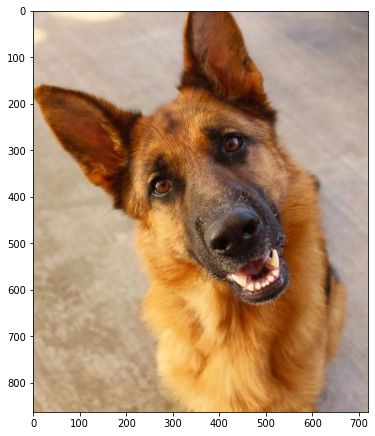

In [9]:
img=skimage.io.imread("dataprepare_machinelearning_pipeline/Images/dog_test.jpg")
plt.figure(figsize=(6,10))
plt.imshow(img);

In [10]:
# hog transform
img_re=skimage.transform.rescale(img,1/3).reshape((288,240))
gray=skimage.color.rgb2gray(img_re)
feature_vector,hog_img=skimage.feature.hog(gray,orientations=9,
                                          pixels_per_cell=(14,14),
                                          cells_per_block=(2,2),
                                          visualize=True)


/home/atanuc73/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
len(feature_vector)

10944

In [12]:
gray.shape

(288, 240)

In [13]:
863*720

621360

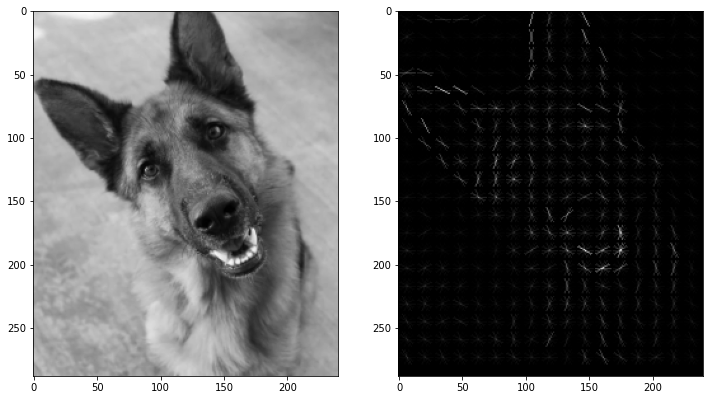

In [14]:
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(gray,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(hog_img,cmap='gray');

### Preprocessing
> GrayScale
<br>
> HOG(Histogram Oriented Gradient) Transformer

In [15]:
from sklearn.base import BaseEstimator,TransformerMixin

In [16]:
from skimage.color import rgb2gray

In [17]:
class rgb2gray_transform(BaseEstimator,TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])

In [18]:
x_train.shape

(1618, 80, 80, 3)

In [19]:
rgbgrayObj=rgb2gray_transform()
x_train_gray=rgbgrayObj.fit_transform(x_train)

In [20]:
x_train_gray.shape

(1618, 80, 80)

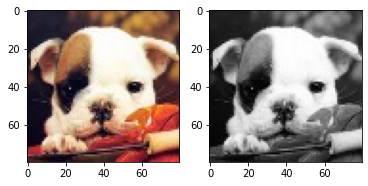

In [21]:
plt.subplot(1,2,1)
plt.imshow(x_train[30])
plt.subplot(1,2,2)
plt.imshow(x_train_gray[30],cmap='gray')

In [23]:
class Hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=9,pixals_per_cell=(8,8),cells_per_block=(3,3)):
        self.orientations=orientations
        self.pixals_per_cell=pixals_per_cell
        self.cells_per_block=cells_per_block
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features=skimage.feature.hog(img,orientations=self.orientations,
                                            pixels_per_cell=self.pixals_per_cell,
                                            cells_per_block=self.cells_per_block)
            
            return hog_features
        
        hfeatures=np.array([local_hog(x) for x in X])
        return hfeatures

In [24]:
hogt=Hogtransformer()
x_train_hog=hogt.fit_transform(x_train_gray)

In [25]:
x_train_hog.shape

(1618, 5184)

## Training machine Learning Model

In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
from sklearn.preprocessing import StandardScaler


In [27]:
model_sgd=SGDClassifier(loss="hinge",learning_rate='adaptive',
                       early_stopping=True,eta0=0.1)

In [28]:
grayify=rgb2gray_transform()
hogify=Hogtransformer()
scalify=StandardScaler()

In [30]:
#Pipeline
# step-1: convert into grayscale
x_train_gray=grayify.fit_transform(x_train)
# step-2: extract the features
x_train_hog=hogify.fit_transform(x_train_gray)
# step-3: Normalization
x_train_scale=scalify.fit_transform(x_train_hog)
# step-4: machine learning
model_sgd.fit(x_train_scale,y_train)


SGDClassifier(early_stopping=True, eta0=0.1, learning_rate='adaptive')

In [31]:
# step-1: convert into grayscale
x_test_gray=grayify.fit_transform(x_test)
# step-2: extract the features
x_test_hog=hogify.fit_transform(x_test_gray)
# step-3: Normalization
x_test_scale=scalify.fit_transform(x_test_hog)

y_pred_test=model_sgd.predict(x_test_scale)

In [32]:
y_pred_test

array(['cat', 'human', 'dog', 'dog', 'eagle', 'panda', 'tiger',
       'elephant', 'cat', 'pigeon', 'pigeon', 'wolf', 'dog', 'cat',
       'pigeon', 'tiger', 'pigeon', 'eagle', 'mouse', 'tiger', 'chicken',
       'chicken', 'monkey', 'mouse', 'pigeon', 'panda', 'bear', 'wolf',
       'cow', 'chicken', 'deer', 'rabbit', 'dog', 'human', 'deer',
       'tiger', 'chicken', 'human', 'human', 'bear', 'panda', 'tiger',
       'panda', 'monkey', 'mouse', 'chicken', 'sheep', 'cat', 'bear',
       'chicken', 'sheep', 'human', 'chicken', 'wolf', 'elephant', 'wolf',
       'lion', 'lion', 'cow', 'monkey', 'sheep', 'tiger', 'dog', 'panda',
       'human', 'cat', 'tiger', 'deer', 'mouse', 'duck', 'mouse',
       'rabbit', 'human', 'mouse', 'duck', 'duck', 'eagle', 'human',
       'cow', 'pigeon', 'cat', 'tiger', 'cow', 'dog', 'lion', 'panda',
       'dog', 'mouse', 'panda', 'monkey', 'tiger', 'panda', 'eagle',
       'elephant', 'cat', 'human', 'sheep', 'wolf', 'sheep', 'pigeon',
       'chicken', '

## Model Evaluation


In [35]:
cr=sklearn.metrics.classification_report(y_test,y_pred_test,output_dict=True)
pd.DataFrame(cr).T

,precision,recall,f1-score,support
bear,0.533333,0.400000,0.457143,20.000000
cat,0.642857,0.843750,0.729730,32.000000
chicken,0.500000,0.550000,0.523810,20.000000
cow,0.647059,0.550000,0.594595,20.000000
deer,0.772727,0.850000,0.809524,20.000000
dog,0.360000,0.333333,0.346154,27.000000
duck,0.687500,0.550000,0.611111,20.000000
eagle,0.538462,0.368421,0.437500,19.000000
elephant,0.631579,0.600000,0.615385,20.000000
human,0.703704,0.950000,0.808511,20.000000


In [36]:
metrics.cohen_kappa_score(y_test,y_pred_test)

0.5405617934075

## PipeLine Model

In [37]:
from sklearn.pipeline import Pipeline
model_pipeline=Pipeline([
    ('grayscale',rgb2gray_transform()),
    ('hogtransform',Hogtransformer(orientations=8,pixals_per_cell=(10,10),cells_per_block=(3,3))),
    ('scale',StandardScaler()),
    ('sgd',SGDClassifier(loss="hinge",learning_rate='adaptive',eta0=0.001))
])

In [38]:
model_pipeline.fit(x_train,y_train)

Pipeline(steps=[('grayscale', rgb2gray_transform()),
                ('hogtransform',
                 hogtransformer(orientations=8, pixals_per_cell=(10, 10))),
                ('scale', StandardScaler()),
                ('sgd', SGDClassifier(eta0=0.001, learning_rate='adaptive'))])

In [39]:
y_pred=model_pipeline.predict(x_test)
y_pred

array(['dog', 'human', 'chicken', 'tiger', 'eagle', 'panda', 'tiger',
       'elephant', 'cat', 'eagle', 'cat', 'cat', 'dog', 'chicken',
       'pigeon', 'tiger', 'pigeon', 'eagle', 'mouse', 'mouse', 'chicken',
       'chicken', 'monkey', 'pigeon', 'tiger', 'panda', 'bear', 'wolf',
       'cow', 'eagle', 'deer', 'dog', 'pigeon', 'human', 'bear', 'eagle',
       'elephant', 'dog', 'human', 'mouse', 'bear', 'dog', 'panda', 'dog',
       'elephant', 'human', 'sheep', 'cat', 'cat', 'chicken', 'wolf',
       'human', 'chicken', 'mouse', 'pigeon', 'wolf', 'lion', 'elephant',
       'duck', 'bear', 'mouse', 'tiger', 'human', 'panda', 'human', 'cat',
       'tiger', 'deer', 'lion', 'duck', 'mouse', 'cat', 'human', 'mouse',
       'duck', 'cow', 'panda', 'human', 'cow', 'cow', 'cow', 'tiger',
       'tiger', 'lion', 'wolf', 'panda', 'lion', 'dog', 'dog', 'pigeon',
       'tiger', 'cow', 'eagle', 'eagle', 'cat', 'human', 'sheep', 'wolf',
       'duck', 'pigeon', 'chicken', 'panda', 'pigeon', 'pa

In [41]:
cr=sklearn.metrics.classification_report(y_test,y_pred,output_dict=True)

/home/atanuc73/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/atanuc73/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/atanuc73/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
pd.DataFrame(cr).T

,precision,recall,f1-score,support
bear,0.523810,0.550000,0.536585,20.000000
cat,0.527778,0.593750,0.558824,32.000000
chicken,0.812500,0.650000,0.722222,20.000000
cow,0.500000,0.550000,0.523810,20.000000
deer,0.866667,0.650000,0.742857,20.000000
dog,0.394737,0.555556,0.461538,27.000000
duck,0.866667,0.650000,0.742857,20.000000
eagle,0.434783,0.526316,0.476190,19.000000
elephant,0.600000,0.450000,0.514286,20.000000
human,0.750000,0.900000,0.818182,20.000000


## Grid Search
> Hyperparameter

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
estimator=Pipeline([
    ('grayscale',rgb2gray_transform()),
    ('hogtransform',Hogtransformer()),
    ('scale',StandardScaler()),
    ('sgd',SGDClassifier())
])

In [49]:
param_grid=[
    {
        'hogtransform__orientations':[7,8,9,10],
        'hogtransform__pixals_per_cell':[(7,7),(8,8),(9,9)],
        'hogtransform__cells_per_block':[(2,2),(3,3)],
        'sgd__loss' : ['hinge','squared_hinge','perceptron'],
        'sgd__learning_rate': ['optimal']
    },
    {
        'hogtransform__orientations':[7,8,9,10],
        'hogtransform__pixals_per_cell':[(7,7),(8,8),(9,9)],
        'hogtransform__cells_per_block':[(2,2),(3,3)],
        'sgd__loss' : ['hinge','squared_hinge','perceptron'],
        'sgd__learning_rate': ['adaptive'],
        'sgd__eta0':[0.001,0.01]
    }
]

In [50]:
model_grid=GridSearchCV(estimator,param_grid=param_grid,
                       scoring='accuracy',n_jobs=1,cv=3,verbose=2)

In [51]:
model_grid.fit(x_train,y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(7, 7), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   6.2s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(7, 7), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   6.1s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(7, 7), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   6.0s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(7, 7), sgd__learning_rate=optimal, sgd__loss=squared_hinge; total time=   6.1s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(7, 7), sgd__learning_rate=optimal, sgd__loss=squared_hinge; total time=   6.2s
[CV] END hogtransform__cel

[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   3.7s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   3.7s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   3.8s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__learning_rate=optimal, sgd__loss=squared_hinge; total time=   3.9s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__learning_rate=optimal, sgd__loss=squared_hinge; total time=   3.8s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=8, hogtransform

[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtransform__pixals_per_cell=(8, 8), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   5.9s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtransform__pixals_per_cell=(8, 8), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   6.0s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtransform__pixals_per_cell=(8, 8), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   6.1s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtransform__pixals_per_cell=(8, 8), sgd__learning_rate=optimal, sgd__loss=squared_hinge; total time=   6.1s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtransform__pixals_per_cell=(8, 8), sgd__learning_rate=optimal, sgd__loss=squared_hinge; total time=   6.0s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtra

[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(7, 7), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   7.1s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(7, 7), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   7.1s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(7, 7), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   7.2s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(7, 7), sgd__learning_rate=optimal, sgd__loss=squared_hinge; total time=   6.9s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(7, 7), sgd__learning_rate=optimal, sgd__loss=squared_hinge; total time=   7.1s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform

[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=9, hogtransform__pixals_per_cell=(9, 9), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   4.0s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=9, hogtransform__pixals_per_cell=(9, 9), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   4.1s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=9, hogtransform__pixals_per_cell=(9, 9), sgd__learning_rate=optimal, sgd__loss=hinge; total time=   4.3s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=9, hogtransform__pixals_per_cell=(9, 9), sgd__learning_rate=optimal, sgd__loss=squared_hinge; total time=   4.1s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=9, hogtransform__pixals_per_cell=(9, 9), sgd__learning_rate=optimal, sgd__loss=squared_hinge; total time=   4.1s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=9, hogtransform

[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=   8.2s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=   9.1s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=   9.0s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=   9.0s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=   9.0s
[CV] E

[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=   5.1s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=   5.0s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=   5.1s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=   5.0s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=7, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=perceptron; total ti

[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=   5.2s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=   5.2s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=   5.2s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=   4.8s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=   4.8s

[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=9, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=   7.9s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=9, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=   7.9s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=9, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=   7.9s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=9, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=   7.9s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=9, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=hinge; total time= 

[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=  11.2s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=  11.2s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=  11.3s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=  11.1s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time

[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=   6.3s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=   6.6s
[CV] END hogtransform__cells_per_block=(2, 2), hogtransform__orientations=10, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=   6.5s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=7, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=  13.1s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=7, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=  12.9s


[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=7, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=   6.1s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=7, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=   4.7s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=7, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=   4.7s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=7, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=   4.7s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=7, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=perceptron; total

[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=  10.4s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=  10.3s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=  11.6s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=  11.5s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=  11.6s
[CV] END

/home/atanuc73/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:577: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=   9.7s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=   9.1s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=   5.9s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=   6.0s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=8, hogtransform__pixals_per_cell=(9, 9), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=perceptron; tot

[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=9, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=  12.8s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=9, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=  12.6s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=9, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=hinge; total time=  13.0s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=9, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=  12.6s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=9, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=  12.7s
[CV]

[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=10, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=squared_hinge; total time=  17.0s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=10, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=  17.2s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=10, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=  17.3s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=10, hogtransform__pixals_per_cell=(7, 7), sgd__eta0=0.01, sgd__learning_rate=adaptive, sgd__loss=perceptron; total time=  17.3s
[CV] END hogtransform__cells_per_block=(3, 3), hogtransform__orientations=10, hogtransform__pixals_per_cell=(8, 8), sgd__eta0=0.001, sgd__learning_rate=adaptive, sgd__loss=hinge; total time

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('grayscale', rgb2gray_transform()),
                                       ('hogtransform', Hogtransformer()),
                                       ('scale', StandardScaler()),
                                       ('sgd', SGDClassifier())]),
             n_jobs=1,
             param_grid=[{'hogtransform__cells_per_block': [(2, 2), (3, 3)],
                          'hogtransform__orientations': [7, 8, 9, 10],
                          'hogtransform__pixals_per_cell': [(7, 7), (8, 8),
                                                            (9, 9)],
                          'sgd__learning_rate': ['optimal'],
                          'sgd__loss': ['hinge', 'squared_hinge',
                                        'perceptron']},
                         {'hogtransform__cells_per_block': [(2, 2), (3, 3)],
                          'hogtransform__orientations': [7, 8, 9, 10],
                          'hogtransform__pixals_

In [52]:
model_grid.best_params_

{'hogtransform__cells_per_block': (2, 2),
 'hogtransform__orientations': 10,
 'hogtransform__pixals_per_cell': (8, 8),
 'sgd__learning_rate': 'optimal',
 'sgd__loss': 'perceptron'}

In [53]:
model_grid.best_score_

0.7175404842071509

In [54]:
model_best = model_grid.best_estimator_

In [55]:
y_pred=model_best.predict(x_test)

In [57]:
cr=sklearn.metrics.classification_report(y_test,y_pred,output_dict=True)
pd.DataFrame(cr).T

/home/atanuc73/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/atanuc73/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/atanuc73/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
bear,0.857143,0.900000,0.878049,20.00000
cat,0.896552,0.812500,0.852459,32.00000
chicken,0.944444,0.850000,0.894737,20.00000
cow,0.684211,0.650000,0.666667,20.00000
deer,0.791667,0.950000,0.863636,20.00000
dog,0.740741,0.740741,0.740741,27.00000
duck,0.750000,0.600000,0.666667,20.00000
eagle,0.684211,0.684211,0.684211,19.00000
elephant,0.800000,0.800000,0.800000,20.00000
human,0.904762,0.950000,0.926829,20.00000


In [58]:
# Save the Model
pickle.dump(model_best,open('dsa_model_best.pickle','wb'))

## Make Pipeline

{'hogtransform__cells_per_block': (2, 2), 

 'hogtransform__orientations': 10,  
 
 'hogtransform__pixals_per_cell': (8, 8), 
 
 'sgd__learning_rate': 'optimal',  
 
 'sgd__loss': 'perceptron'}  

In [59]:
from sklearn.pipeline import make_pipeline
pipeline1=make_pipeline(rgb2gray_transform(),
                       Hogtransformer(orientations=10,
                                     pixals_per_cell=(8,8),
                                     cells_per_block=(2,2)))

In [60]:
feature_vector=pipeline1.fit_transform(x_train)

In [61]:
# Standard scaler
scaler=StandardScaler()
transformed_xtrain=scaler.fit_transform(feature_vector)

In [62]:
model=SGDClassifier(learning_rate='optimal',loss='hinge',alpha=0.01,early_stopping=True)

In [63]:
model.fit(transformed_xtrain,y_train)

SGDClassifier(alpha=0.01, early_stopping=True)

In [64]:
# evaluate
feature_vector=pipeline1.fit_transform(x_test)
transformed_x=scaler.transform(feature_vector)
y_pred_test=model.predict(transformed_x)

In [66]:
cr=pd.DataFrame(metrics.classification_report(y_test,y_pred_test,output_dict=True)).T
cr

/home/atanuc73/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/atanuc73/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/atanuc73/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
bear,0.809524,0.850000,0.829268,20.000000
cat,0.896552,0.812500,0.852459,32.000000
chicken,0.888889,0.800000,0.842105,20.000000
cow,0.933333,0.700000,0.800000,20.000000
deer,0.863636,0.950000,0.904762,20.000000
dog,0.700000,0.777778,0.736842,27.000000
duck,0.750000,0.600000,0.666667,20.000000
eagle,0.714286,0.526316,0.606061,19.000000
elephant,0.739130,0.850000,0.790698,20.000000
human,1.000000,0.900000,0.947368,20.000000


In [68]:
# save models for flask app
pickle.dump(model,open('dsa_image_classification_sgd.pickle','wb'))
pickle.dump(scaler,open('dsa_scaler.pickle','wb'))

## Output analysis

In [70]:
model_p=pickle.load(open('dsa_model_best.pickle','rb'))

In [71]:
model_p.get_params()

{'memory': None,
 'steps': [('grayscale', rgb2gray_transform()),
  ('hogtransform', Hogtransformer(cells_per_block=(2, 2), orientations=10)),
  ('scale', StandardScaler()),
  ('sgd', SGDClassifier(loss='perceptron'))],
 'verbose': False,
 'grayscale': rgb2gray_transform(),
 'hogtransform': Hogtransformer(cells_per_block=(2, 2), orientations=10),
 'scale': StandardScaler(),
 'sgd': SGDClassifier(loss='perceptron'),
 'hogtransform__cells_per_block': (2, 2),
 'hogtransform__orientations': 10,
 'hogtransform__pixals_per_cell': (8, 8),
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'sgd__alpha': 0.0001,
 'sgd__average': False,
 'sgd__class_weight': None,
 'sgd__early_stopping': False,
 'sgd__epsilon': 0.1,
 'sgd__eta0': 0.0,
 'sgd__fit_intercept': True,
 'sgd__l1_ratio': 0.15,
 'sgd__learning_rate': 'optimal',
 'sgd__loss': 'perceptron',
 'sgd__max_iter': 1000,
 'sgd__n_iter_no_change': 5,
 'sgd__n_jobs': None,
 'sgd__penalty': 'l2',
 'sgd__power_t': 0.5,
 'sgd_